# Create map of growth barriers (fragmentation and radial drift) for a given protoplanetary disk model

### Import necessary libraries and set constants in cgs

In [1]:
import numpy as np
from astropy import constants as c
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
from matplotlib import animation, rc
from IPython.display import HTML

au = u.au.to(u.cm)
year = u.year.to(u.s)
k_b = c.k_B.cgs.value
m_p = c.m_p.cgs.value
Grav = c.G.cgs.value
M_sun = c.M_sun.cgs.value
AH2 = 2.e-15

# Set parameters of the model

### We use a standard viscous disk profile (power-law with exponential cut-off)

In [2]:
mdisk = 0.05 * M_sun  # disk mass
rc = 60. * au         # disk cut-off radius
alpha = 1.e-3         # turbulence strength parameter (regulates impact speeds and settling)
dtg = 0.01            # dust-to-gas ratio
Htr = 0.05            # disk aspect ratio H/r (regulates temperature)
vfrag = 1.e3          # fragmentation threshold (cm/s)
rhop = 1.             # internal density of dust particles

## Set radial and size grids

In [3]:
rgrid = np.logspace(-1,3,1000)*au
agrid = np.logspace(-4,4,1000)

## Calculate densities, pressure gradient, Stokes number in every (r,a) bin

In [5]:
# gas surface density
sigmagas = mdisk / (2.*np.pi*rc**2.) * (rc/rgrid) * np.exp(-1.*(rgrid/rc))
# grid cell size
dr = rgrid[1:]-rgrid[:-1]
# Keplerian frequency
omegaK = np.sqrt(Grav*M_sun/rgrid**3.)
# dust surface density
sigmad = dtg * sigmagas
# sound speed
cs = Htr * omegaK * rgrid
# temperature
temperature = 2.34*m_p*cs**2./k_b
# gas scale-height
H_g = cs/omegaK
# gas midplane density
rhog = sigmagas / (np.sqrt(2.*np.pi)*H_g)
# gas pressure
pressure = rhog * cs**2.
# pressure gradient
dpdr = (pressure[1:]-pressure[:-1])/dr
# eta parameter (difference between gas and Keplerian rotation)
eta = dpdr / (2.*rhog[:-1]*omegaK[:-1]**2.*rgrid[:-1])
# maximum drift speed
maxdriftvel = eta*omegaK[:-1]*rgrid[:-1]
# mean-free path in gas
lmfp = 2.34*m_p/(rhog*AH2)
# Stokes number at every (r,a)
stokesnr = np.zeros((np.size(rgrid),np.size(agrid)))
for ia in range(np.size(agrid)):
    for ir in range(np.size(rgrid)): 
        stokesnr[ir,ia] = np.pi*0.5*agrid[ia]/sigmagas[ir]
        if (agrid[ia] > 9.*0.25*lmfp[ir]):
            stokesnr[ir,ia] = stokesnr[ir,ia] * 4.*agrid[ia]/(9.*lmfp[ir])
# dust midplane density at every (r,a) (assuming that all dust is the same size)
rhod = np.zeros((np.size(rgrid),np.size(agrid)))
for ia in range(np.size(agrid)):
    rhod[:,ia] = sigmad[:] / (np.sqrt(2.*np.pi)*H_g[:]*np.sqrt(alpha/(alpha+stokesnr[:,ia])))

## Plot Stokes number contours and Stokes drag regime

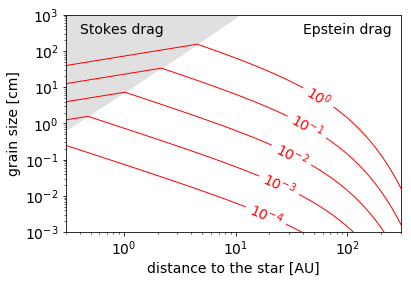

In [6]:
plt.rcParams.update({'font.size': 14})

f,ax=plt.subplots()

ax.set_xlabel('distance to the star [AU]')
ax.set_ylabel('grain size [cm]')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.3,300)
ax.set_ylim(1.e-3,1000)

ratio = np.zeros((np.size(rgrid),np.size(agrid)))
for ia in range(np.size(agrid)):
    ratio[:,ia] = agrid[ia] / lmfp[:]

Stdr = ax.contourf(rgrid/au,agrid,ratio.T,levels=[2.25,10000000],colors='#E0E0E0')
St = ax.contour(rgrid/au,agrid,stokesnr[:, :].T, levels=[1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.], colors="red", linewidths=1)
fmt = mticker.LogFormatterMathtext()
pos = [(100,100),(45,1), (30,0.1), (22,0.01), (16,0.001)]
ax.clabel(St,inline=True,manual=pos,fmt=fmt)
ax.text(0.4,300,'Stokes drag')
ax.text(40,300,'Epstein drag')

f.savefig('stokes_nr.pdf',bbox_inches = "tight")

## Calculate the turbulent impact speeds according to Ormel & Cuzzi (2007)
### Note: this is for collisions between grains of St and 0.5·St

In [7]:
c0      =  1.6015125
c1      = -0.63119577
c2      =  0.32938936
c3      = -0.29847604
ya      =  1.6
yap1inv =  1./ (1. + ya)

OmKinv    = 1. / omegaK
Re        = 0.5 * alpha * sigmagas * AH2 / (2.34*m_p)
ReInvSqrt = np.sqrt(1. / Re)
vn        = np.sqrt(alpha) * cs
vs        = Re**(-0.25) * vn
ts        = OmKinv * ReInvSqrt
vg2       = 1.5 * vn**2

StL = np.zeros((np.size(rgrid),np.size(agrid)))
StS = np.zeros((np.size(rgrid),np.size(agrid)))
eps = np.zeros((np.size(rgrid),np.size(agrid)))
tauL = np.zeros((np.size(rgrid),np.size(agrid)))
tauS = np.zeros((np.size(rgrid),np.size(agrid)))
ys = np.zeros((np.size(rgrid),np.size(agrid)))
h1 = np.zeros((np.size(rgrid),np.size(agrid)))
h2 = np.zeros((np.size(rgrid),np.size(agrid)))

for ia in range(np.size(agrid)):
    StL[:, ia] = stokesnr[:,ia]
    StS[:, ia] = 0.5*stokesnr[:,ia]
    eps[:, ia] = 0.5
    tauL[:, ia] = StL[:, ia] * OmKinv[:]
    tauS[:, ia] = StS[:, ia] * OmKinv[:]
    ys[:, ia] = c0 + c1*StL[:, ia] + c2*StL[:, ia]**2 + c3*StL[:, ia]**3
    h1[:, ia] = (StL[:, ia] - StS[:, ia]) / (StL[:, ia] + StS[:, ia]) * (StL[:, ia] * yap1inv - StS[:, ia]**2 / (StS[:, ia] + ya * StL[:, ia]))
    h2[:, ia] = 2. * (ya * StL[:, ia] - ReInvSqrt[:]) + StL[:, ia] * yap1inv - StL[:, ia]**2 / (StL[:, ia] + ReInvSqrt[:]) + StS[:, ia]**2 / (ya * StL[:, ia] + StS[:, ia]) - StS[:, ia]**2 / (StS[:, ia] + ReInvSqrt[:])

dturb = np.zeros((np.size(rgrid),np.size(agrid)))    
    
for ia in range(np.size(agrid)):
    for ir in range(np.size(rgrid)): 
        if (tauL[ir,ia] < 0.2*ts[ir]):
            dturb[ir,ia] = 1.5 * (vs[ir] / ts[ir] * (tauL[ir,ia] - tauS[ir,ia]))**2
        elif (tauL[ir,ia]*ya < ts[ir]):
            dturb[ir,ia] = vg2[ir] * (StL[ir,ia] - StS[ir,ia]) / (StL[ir,ia] + StS[ir,ia]) * (StL[ir,ia]**2 / (StL[ir,ia] + ReInvSqrt[ir]) - StS[ir,ia]**2 / (StS[ir,ia] + ReInvSqrt[ir]))
        elif (tauL[ir,ia] < 5.*ts[ir]):
            dturb[ir,ia] = vg2[ir] * (h1[ir,ia] + h2[ir,ia])
        elif (tauL[ir,ia] < 0.2*OmKinv[ir]):
            dturb[ir,ia] = vg2[ir] * StL[ir,ia] * (2.*ya - 1. - eps[ir,ia] + 2./(1. + eps[ir,ia]) * (yap1inv + eps[ir,ia]**3/(ya+eps[ir,ia])))
        elif (tauL[ir,ia] < OmKinv[ir]):
            dturb[ir,ia] = vg2[ir] * StL[ir,ia] * (2.*ys[ir,ia] - 1. - eps[ir,ia] + 2./(1.+eps[ir,ia])*(1./(1.+ys[ir,ia]) + eps[ir,ia]**3/(ys[ir,ia]+eps[ir,ia])))
        elif (tauL[ir,ia] >= OmKinv[ir]):
            dturb[ir,ia] = vg2[ir] * (2. + StL[ir,ia] + StS[ir,ia]) / (1. + StL[ir,ia] + StS[ir,ia] + StL[ir,ia]*StS[ir,ia])

## Total impact speed calculation (turbulence + radial and azimuthal drift)
### Note: this is for collisions between grains of St and 0.5·St

In [8]:
relvel = np.zeros((np.size(rgrid),np.size(agrid)))
for ia in range(np.size(agrid)):
   relvel[:-1,ia] = np.sqrt(dturb[:-1,ia]+ (eta*omegaK[:-1]*rgrid[:-1])**2.*((2.*stokesnr[:-1,ia]/(1.+stokesnr[:-1,ia]**2.)-stokesnr[:-1,ia]/(1.+0.25*stokesnr[:-1,ia]**2.))**2.+(1./(1.+stokesnr[:-1,ia]**2.)-1./(1.+0.25*stokesnr[:-1,ia]**2.))**2.))

## Plot the impact speeds

<a list of 1 text.Text objects>

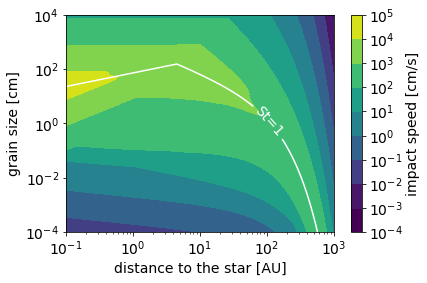

In [10]:
f,ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('distance to the star [AU]')
ax.set_ylabel('grain size [cm]')

cc = ax.contourf(rgrid/au,agrid,relvel.T, norm=colors.LogNorm(vmin=0.001, vmax=1.e5))
pSt = ax.contour(rgrid/au, agrid, stokesnr[:, :].T, levels=[1.], colors="white")
clb = plt.colorbar(cc)
clb.set_label('impact speed [cm/s]')
fmt='St=%d'
ax.clabel(pSt,inline=True,manual=[(100,1)],fmt=fmt)

## Calculate the drift and growth timescales

In [11]:
taudrift = np.zeros((np.size(rgrid),np.size(agrid)))
driftvel = np.zeros((np.size(rgrid),np.size(agrid)))
for ia in range(np.size(agrid)):
    driftvel[:-1,ia] = 2.*maxdriftvel[:]*stokesnr[:-1,ia]/(1.+stokesnr[:-1,ia]**2.)
    taudrift[:-1,ia] = rgrid[:-1] / abs(driftvel[:-1,ia])
    
taugrowth = np.zeros((np.size(rgrid),np.size(agrid)))
dadt = np.zeros((np.size(rgrid),np.size(agrid)))
for ia in range(np.size(agrid)):
    dadt[:-1,ia] = (rhod[:-1,ia]*relvel[:-1,ia]) / rhop
    taugrowth[:-1,ia] = agrid[ia] / dadt[:-1,ia]

## Plot the fragmentation and drift barriers

/Users/joanna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


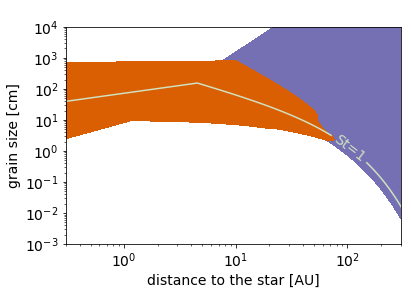

In [12]:
plt.rcParams.update({'font.size': 14})

f,ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.3,300)
ax.set_ylim(1.e-3,1.e4)
ax.set_xlabel('distance to the star [AU]')
ax.set_ylabel('grain size [cm]')

drift = ax.contourf(rgrid/au,agrid,(taugrowth/taudrift).T, levels=[0.3,1000.], colors="#7570b3")
frag = ax.contourf(rgrid/au, agrid, relvel[:, :].T/vfrag, levels=[1.,100000.], colors="#d95f02")
pSt = ax.contour(rgrid/au, agrid, stokesnr[:, :].T, levels=[1.], colors="#d0e0c0")
aa = mticker.LogFormatterMathtext()
ax.clabel(pSt,inline=True,manual=[(100,1)],fmt='St=%d')
ax.set_title(" ")
f.savefig("barriers.pdf",bbox_inches='tight')
f.savefig('barriers.pdf',bbox_inches = "tight")

## Integrate test particles tracks (it make take a while for a low dt / high tend)

In [13]:
time = 0.0
rpos = np.logspace(-1,3,10) # initial locations of particles
rpos = rpos*au
nparts = np.size(rpos)
size = np.zeros(nparts) 
size[:] = 1.e-3 # initial size of particles in cm
dt = 0.1*year # time step
tend = 5.e5*year # how long to integrate

nsteps = (tend/dt)
nsteps = np.int_(nsteps)

ttrack = np.zeros(nsteps)
rtrack = np.zeros((nparts,nsteps))
atrack = np.zeros((nparts,nsteps))

it = 0

while (time <tend):
    ia = agrid.searchsorted(size)
    ir = rgrid.searchsorted(rpos)
    for ip in range(nparts):
        if (relvel[ir[ip],ia[ip]]<vfrag):
            size[ip] = size[ip] + dadt[ir[ip],ia[ip]]*dt
        else:
            size[ip] = 0.99*size[ip]
        rpos[ip] = rpos[ip] + driftvel[ir[ip],ia[ip]]*dt
    time = time + dt
    it = it + 1
    rtrack[:,it-1] = rpos[:]
    atrack[:,it-1] = size[:]
    ttrack[it-1] = time/year

## Create an animation out of the test particles tracks

### Choose time snapshots for the animation:

In [14]:
snaphots = np.int_(np.logspace(0,np.log10(nsteps-1),50,base=10))

/Users/joanna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


/Users/joanna/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


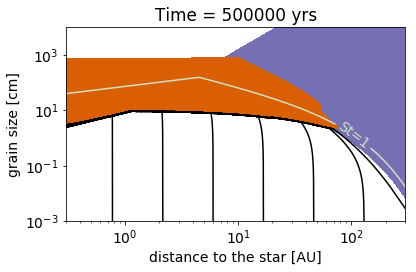

In [15]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.autolayout': True})

f,ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.3,300)
ax.set_ylim(1.e-3,1.e4)
ax.set_xlabel('distance to the star [AU]')
ax.set_ylabel('grain size [cm]')

drift = ax.contourf(rgrid/au,agrid,(taugrowth/taudrift).T, levels=[0.3,100000.], colors="#7570b3")
frag = ax.contourf(rgrid/au, agrid, relvel[:, :].T/vfrag, levels=[1.,100000.], colors="#d95f02")
pSt = ax.contour(rgrid/au, agrid, stokesnr[:, :].T, levels=[1.], colors="#d0e0c0")
fmt='St=%d'
ax.clabel(pSt,inline=True,manual=[(100,1)],fmt=fmt)

line0, = ax.plot([], [], 'k-')
point0, = ax.plot([], [], 'ko')
line1, = ax.plot([], [], 'k-')
point1, = ax.plot([], [], 'ko')
line2, = ax.plot([], [], 'k-')
point2, = ax.plot([], [], 'ko')
line3, = ax.plot([], [], 'k-')
point3, = ax.plot([], [], 'ko')
line4, = ax.plot([], [], 'k-')
point4, = ax.plot([], [], 'ko')
line5, = ax.plot([], [], 'k-')
point5, = ax.plot([], [], 'ko')
line6, = ax.plot([], [], 'k-')
point6, = ax.plot([], [], 'ko')
line7, = ax.plot([], [], 'k-')
point7, = ax.plot([], [], 'ko')

def init(): 
    line0.set_data([], []) 
    point0.set_data([], [])
    line1.set_data([], []) 
    point1.set_data([], [])
    line2.set_data([], []) 
    point2.set_data([], [])
    line3.set_data([], []) 
    point3.set_data([], [])
    line4.set_data([], []) 
    point4.set_data([], [])
    line5.set_data([], []) 
    point5.set_data([], [])
    line6.set_data([], []) 
    point6.set_data([], [])
    line7.set_data([], []) 
    point7.set_data([], [])
    ax.set_title('Time = 0 yrs')
    return line0, point0, line1, point1, line2, point2, line3, point3, line4, point4, line5, point5, line6, point6, line7, point7,
    
def animate(i): 
    line0.set_data(rtrack[2,:i]/au,atrack[2,:i]) 
    point0.set_data(rtrack[2,i]/au,atrack[2,i])
    line1.set_data(rtrack[3,:i]/au,atrack[3,:i]) 
    point1.set_data(rtrack[3,i]/au,atrack[3,i])
    line2.set_data(rtrack[4,:i]/au,atrack[4,:i]) 
    point2.set_data(rtrack[4,i]/au,atrack[4,i])
    line3.set_data(rtrack[5,:i]/au,atrack[5,:i]) 
    point3.set_data(rtrack[5,i]/au,atrack[5,i])
    line4.set_data(rtrack[6,:i]/au,atrack[6,:i]) 
    point4.set_data(rtrack[6,i]/au,atrack[6,i])
    line5.set_data(rtrack[7,:i]/au,atrack[7,:i]) 
    point5.set_data(rtrack[7,i]/au,atrack[7,i])
    line6.set_data(rtrack[8,:i]/au,atrack[8,:i]) 
    point6.set_data(rtrack[8,i]/au,atrack[8,i])
    line7.set_data(rtrack[9,:i]/au,atrack[9,:i]) 
    point7.set_data(rtrack[9,i]/au,atrack[9,i])
    ax.set_title('Time = %d yrs'%ttrack[i])
    return line0, point0, line1, point1, line2, point2, line3, point3, line4, point4, line5, point5, line6, point6, line7, point7,

Writer = animation.writers['ffmpeg']
writer = Writer()

anim = animation.FuncAnimation(f, animate, init_func=init, frames=snaphots, interval=150, blit=True)
#anim.save('barriers_tracks.mp4',writer=writer,dpi=300) # uncomment to save the animation in higher resolution
HTML(anim.to_html5_video())